# Bayesian optimization applied to database tuning

This notebook illustrates how bayesian optimization may be used to tune the configuration of a database under a defined workload.

An example may be the following:
- We have a PostgreSQL database and we know the content of a typical workload on that database (for example a set of N queries each X minutes).
- We want to fine-tune the meta-parameters defined in the `postgresql.conf` file, for example `work_mem` and `shared_buffers`, so that running the typical workload takes the least amount of time.
- We know these parameters are between a given interval but we can't say the most interesting values, we want to find these values automatically using Bayesian optimization.

Let's implement a solution to answer that kind of problem and visualize results. Since this notebook is only for illustration purposes, we are also going to mock the behavior of the database but thaat part is explicitly specified.

In [1]:
import numpy as np
np.random.seed(666)

from skopt import Optimizer

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import Axes3D

We assume we can change the values of `param_1` and `param_2` and we know that they respectively vary between 0 and 10 and between 0 and 20. This is the search space we want to explore: we want to find the pair of parameters which gives us the minimal time to run a workload.

In [2]:
search_space = {
    'param_1': (0.0, 10.0),
    'param_2': (0.0, 20.0)
}

This part is only here to build a mesh where we can visualize things. 

In [3]:
x_graph = np.arange(search_space['param_1'][0], search_space['param_1'][1], 0.5)
y_graph = np.arange(search_space['param_2'][0], search_space['param_2'][1], 0.5)

X, Y = np.meshgrid(x_graph, y_graph)

## Mocking the behavior of the database

In reality, we don't know how the database will behave when setting the parameters. Since we're only here to illustrate the process, we assume we already know how long it takes to run a workload under a specific set of parameters `param_1, param_2`. Let's mock that behavior and visualize it.

In [4]:
def true_function(x):
    y = (x[0] - 6) ** 2 + ((x[1] - 13) / 2) ** 2 + 30
    return y

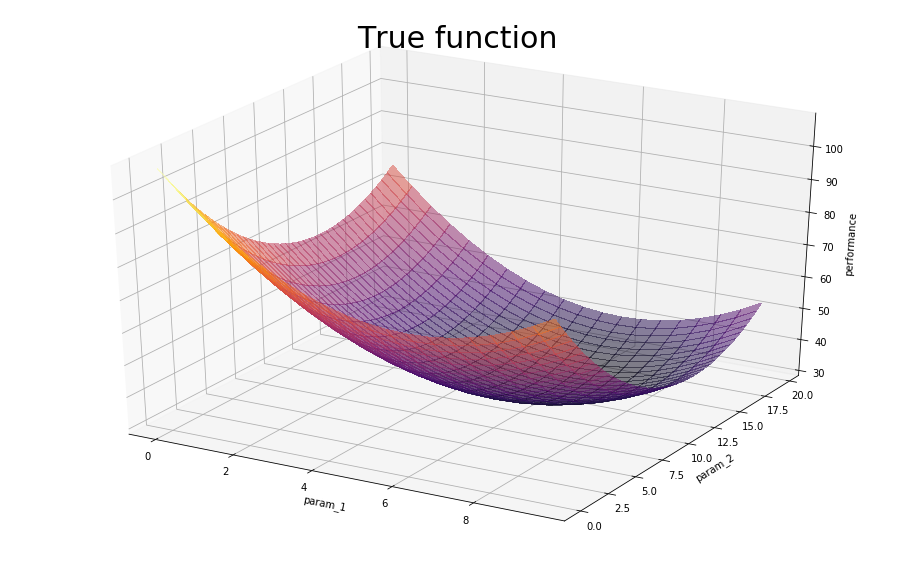

In [5]:
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('True function', fontdict={'size':30})

z_graph = np.array([true_function([x, y]) for x, y in zip(np.ravel(X), np.ravel(Y))])
Z = z_graph.reshape(X.shape)

ax.set_xlabel('param_1')
ax.set_ylabel('param_2')
ax.set_zlabel('performance')
ax.plot_surface(X, Y, Z, cmap=cm.inferno, linewidth=0, antialiased=False, alpha=0.5)

Here is the behavior of the database. We can see from the graph (and from the definition of `true_function()`) that the minimum can be reached in `(param_1, param_2) = (6, 13)`.

*Again, in reality we do not have this kind of information before starting the optimization session.*

## Running the optimization

We are using `scikit-optimize` to run our optimization, a neat Python package built on top of `scikit-learn`.

We are going to need an `skopt.Optimizer` object instantiated with the search space (defined above) and the type of estimator to use (we are using the default Gaussian Process estimator, based on `sklearn.GaussianProcessRegressor`). By default, `scikit-optimize` will start with `n_initial_points=10`, which means the first ten observations will be based on random tests so that it populates the space of observations. In reality, ten observations could already take a lot of time (for instance in our case we need to run a workload on a database for each observation). Let's reduce that to three initial points (a small `n_initial_points` may cause trouble for the `Optimizer` to start catching on, especially if there is a high number of dimensions).

In [6]:
opt = Optimizer([(0.0, 10.0), (0.0, 20.0)], 
                "GP", 
                n_initial_points=3)

Let's now start off the optimization session. As we said, we are going to mock the behavior of our database by calling `true_function()` when in reality we would have to run a workload and see how the database perfoms under a specific set of parameters.

We start off by running the first three observations that are based on random tests.

In [7]:
for _ in range(3):
    # What value should we test next?
    next_x = opt.ask()
    
    # Here we call true_function(next_x) to get the value of our observation
    # In practice we would have to run a benchmark to get the performance
    f_val = true_function(next_x)
    
    print('Set of parameters tested: {{param_1: {}, param_2: {}}} - Performance: {}s'.format(round(next_x[0]),
                                                                                             round(next_x[1]),
                                                                                             round(f_val)))
    
    opt.tell(next_x, f_val)

Set of parameters tested: {param_1: 1.0, param_2: 4.0} - Performance: 74.0s
Set of parameters tested: {param_1: 1.0, param_2: 15.0} - Performance: 53.0s
Set of parameters tested: {param_1: 3.0, param_2: 5.0} - Performance: 53.0s


The following function will help us to visualize each step (that is to say how the `Optimizer` estimates the database behavior).

In [8]:
def plot_optimizer(opt, iteration, next_value):
    # Extracting the sklearn GaussianProcessRegressor model to help us visualize
    model = opt.models[-1]
    
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title('Bayesian optimization after {} iterations \nNext value to test: ({}, {})'.format(iteration, 
                                                                                                   next_value[0], 
                                                                                                   next_value[1]), 
                 fontdict={'size': 20})
        
    # Data should be normalized to be used in skopt.Optimizer (see documentation about skopt.Space)
    # One way to do it is to use Space.transform(), the target warped space can be achieved 
    # through simple normalization here
    z_graph = np.array([model.predict(np.array([x, y]).reshape(1, -1)) for x, y in zip(np.ravel(X / 10), np.ravel(Y / 20))])
    Z = z_graph.reshape(X.shape)

    ax.set_xlabel('param_1')
    ax.set_ylabel('param_2')
    ax.set_zlabel('performance')
    
    # Plotting the GaussianProcess mean estimation
    ax.plot_surface(X, Y, Z, cmap=cm.inferno, linewidth=0, antialiased=False, alpha=0.5)
    
    # Plotting the actual observations
    ax.scatter(xs=[x[0] for x in opt.Xi],
               ys=[x[1] for x in opt.Xi],
               zs=opt.yi, 
               c='r', 
               marker='o',
               s=15**2)

Let's run the optimization loop ten times and see the evolution at each step.

4 - Set of parameters tested: {param_1: 3.0, param_2: 5.0} - Performance: 54.0s
5 - Set of parameters tested: {param_1: 5.0, param_2: 7.0} - Performance: 39.0s
6 - Set of parameters tested: {param_1: 7.0, param_2: 20.0} - Performance: 44.0s
7 - Set of parameters tested: {param_1: 10.0, param_2: 1.0} - Performance: 83.0s
8 - Set of parameters tested: {param_1: 5.0, param_2: 18.0} - Performance: 39.0s
9 - Set of parameters tested: {param_1: 5.0, param_2: 13.0} - Performance: 31.0s
10 - Set of parameters tested: {param_1: 6.0, param_2: 13.0} - Performance: 30.0s
11 - Set of parameters tested: {param_1: 6.0, param_2: 12.0} - Performance: 30.0s
12 - Set of parameters tested: {param_1: 6.0, param_2: 13.0} - Performance: 30.0s


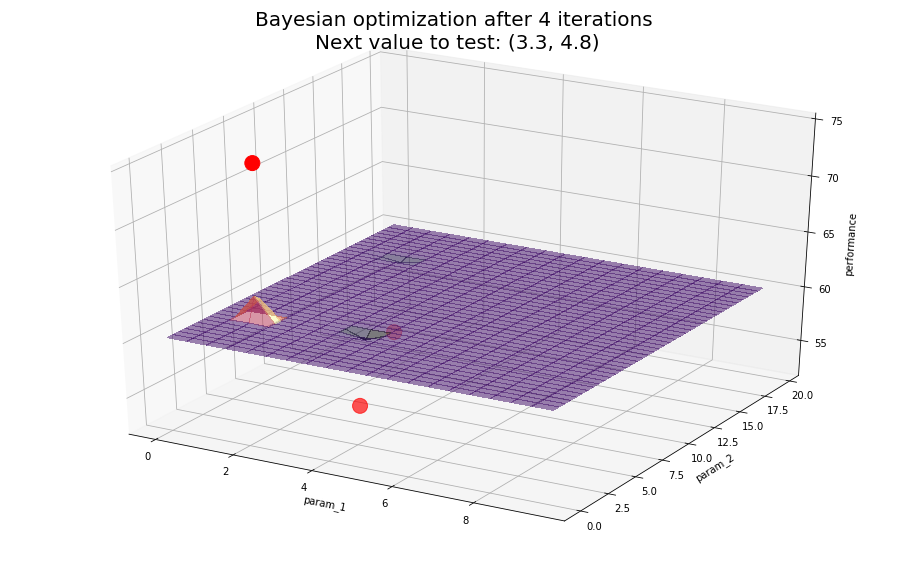

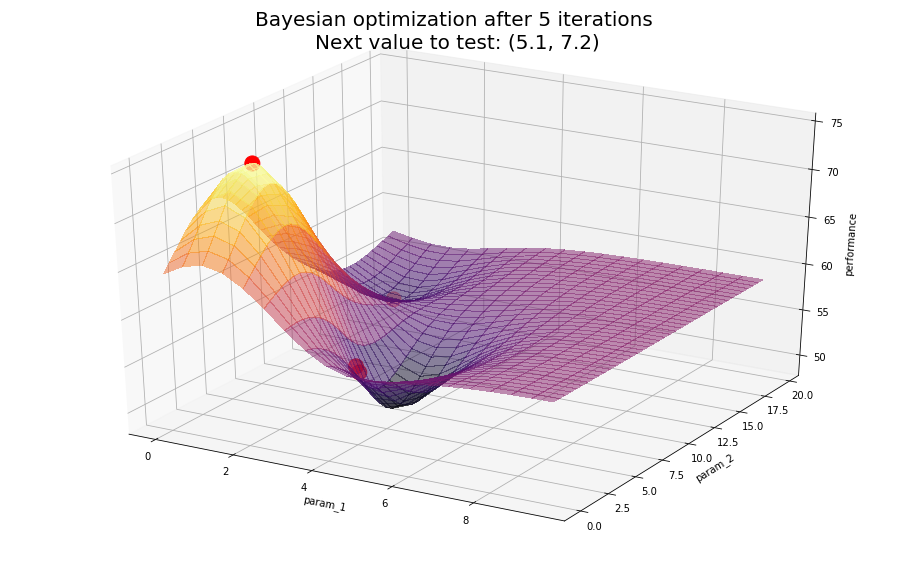

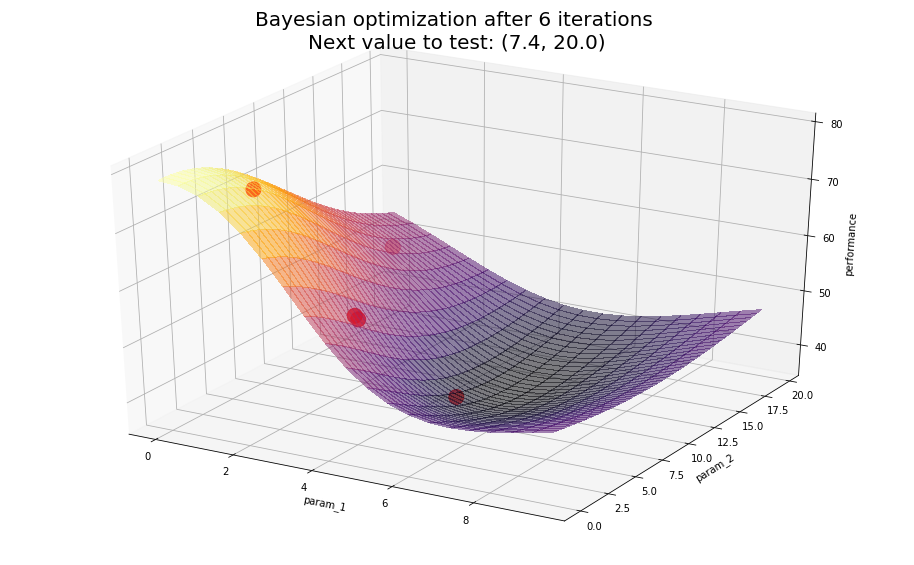

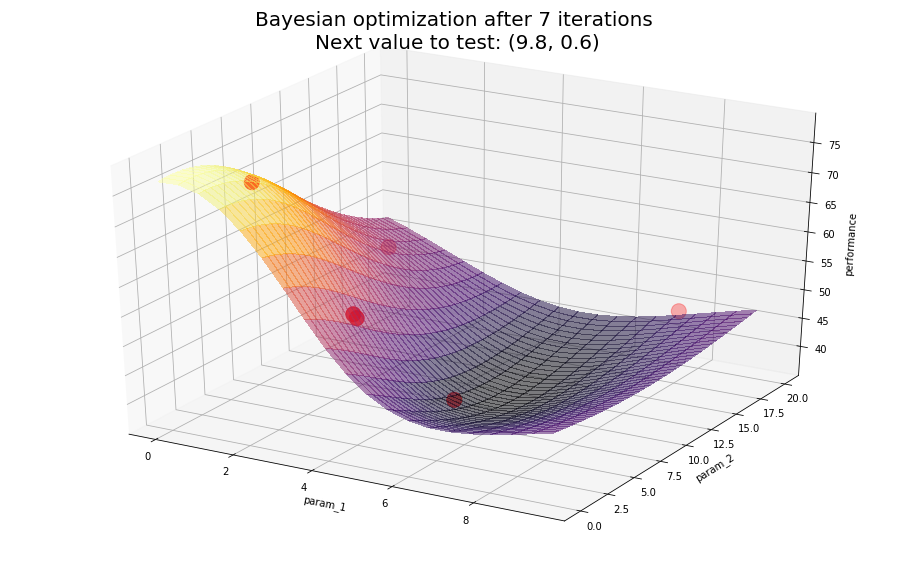

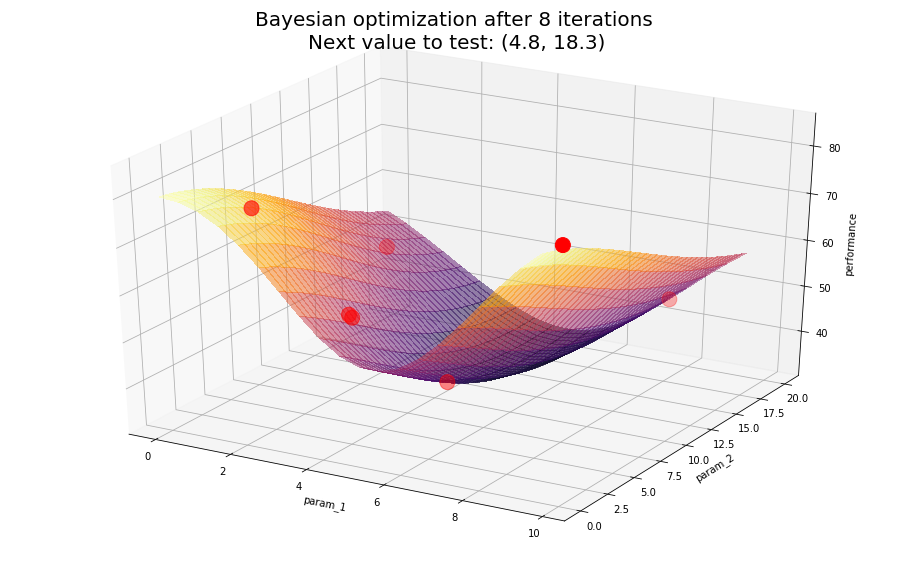

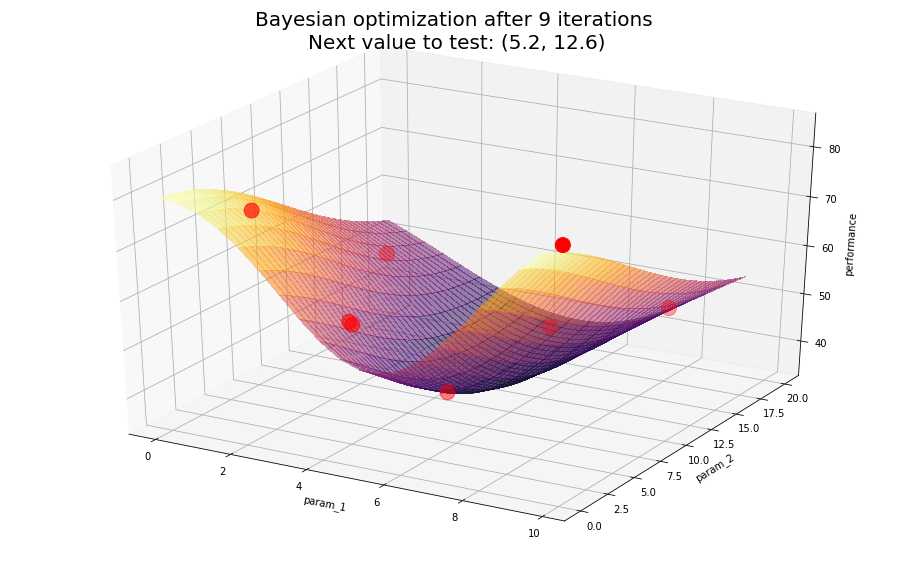

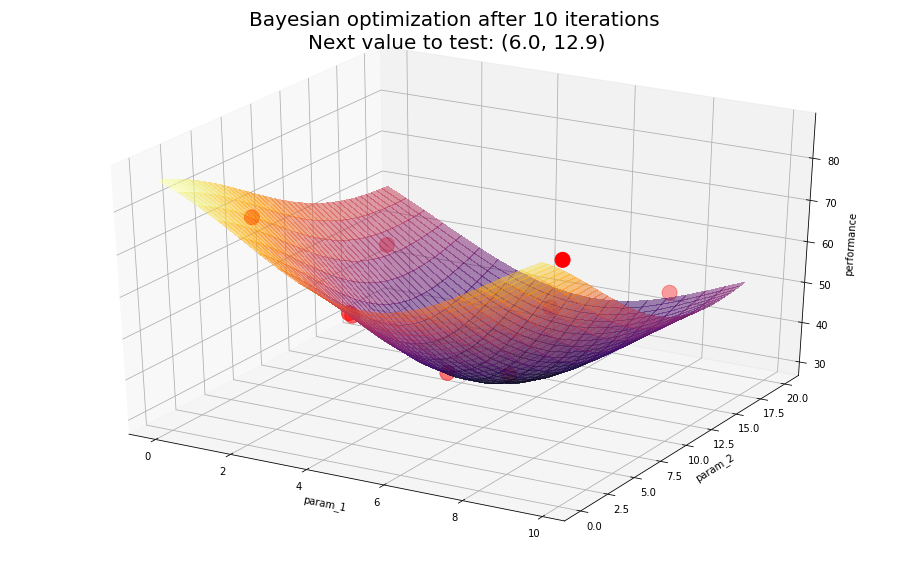

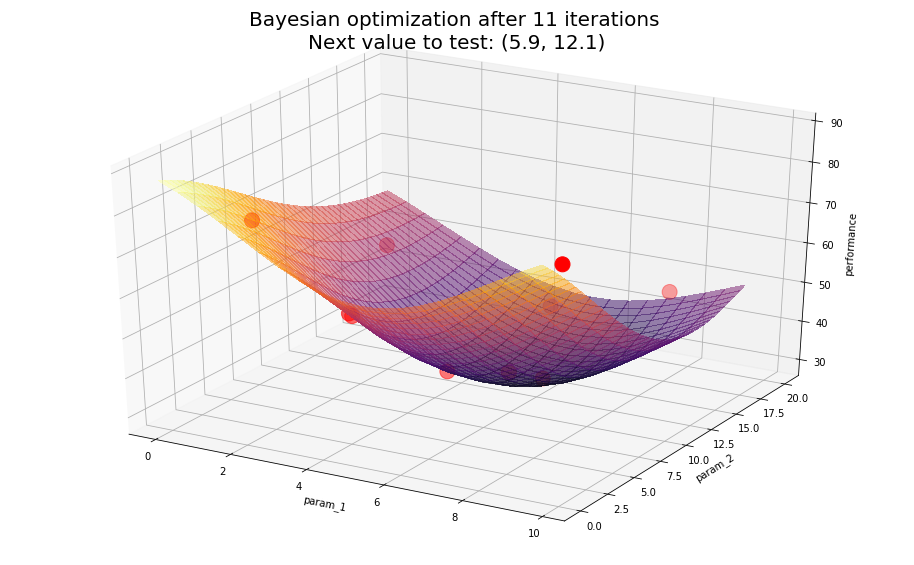

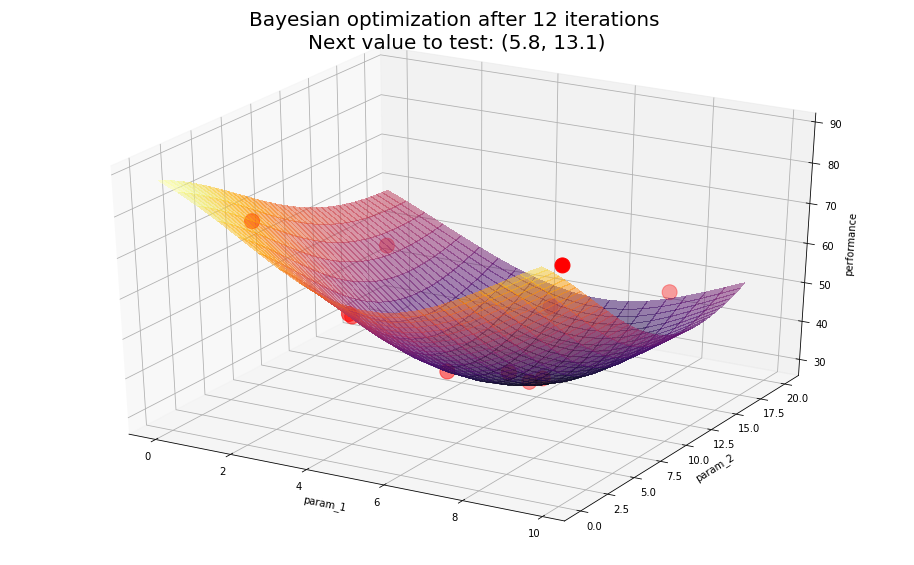

In [9]:
for iteration in range(4, 13):
    next_x = opt.ask()
    plot_optimizer(opt, iteration, np.round(next_x, 1))
    
    # Again, this would translate in a benchmark to get the true value
    f_val = true_function(next_x)
    print('{} - Set of parameters tested: {{param_1: {}, param_2: {}}} - Performance: {}s'.format(iteration,
                                                                                                  round(next_x[0]),
                                                                                                  round(next_x[1]),
                                                                                                  round(f_val)))
    
    opt.tell(next_x, f_val)

We can see that the `Optimizer`, without knowing anything about the actual behavior of the database, converged very quickly and after ten observations, it suggested one of the best possible points.

In our case, we would now know that setting `param_1` to 6 and `param_2` to 13 would provide the best performance under a given workload.

## Conclusion

The Bayesian optimization makes it possible to automatically fine-tune meta-parameters of a database under a specific workload. This approach was done using only two parameters for visualization purposes but may generalized to a higher number of parameters (within reason since each dimension will significantly increase the size of the search space).

Be careful to optimize only *stable* environments. That means if your performance is variable and not related to the parameters whose values you are trying to find, this technique will simply not work (you cannot optimize what is variable). 